## Problem: Anderson's Iris
--> with real-world noise

Imports

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.ensemble import IsolationForest

In [2]:
np.random.seed(42)

loading Dataset

In [3]:
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

In [4]:
df = pd.DataFrame(X, columns=feature_names)
df['species'] = pd.Categorical.from_codes(y, target_names)

In [5]:
print("Original Iris Dataset Shape:", df.shape)
print("\nSample of Original Data:")
print(df.head())
print("\nSummary Statistics:")
print(df.describe())

Original Iris Dataset Shape: (150, 5)

Sample of Original Data:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  

Summary Statistics:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000 

<Figure size 1200x1000 with 0 Axes>

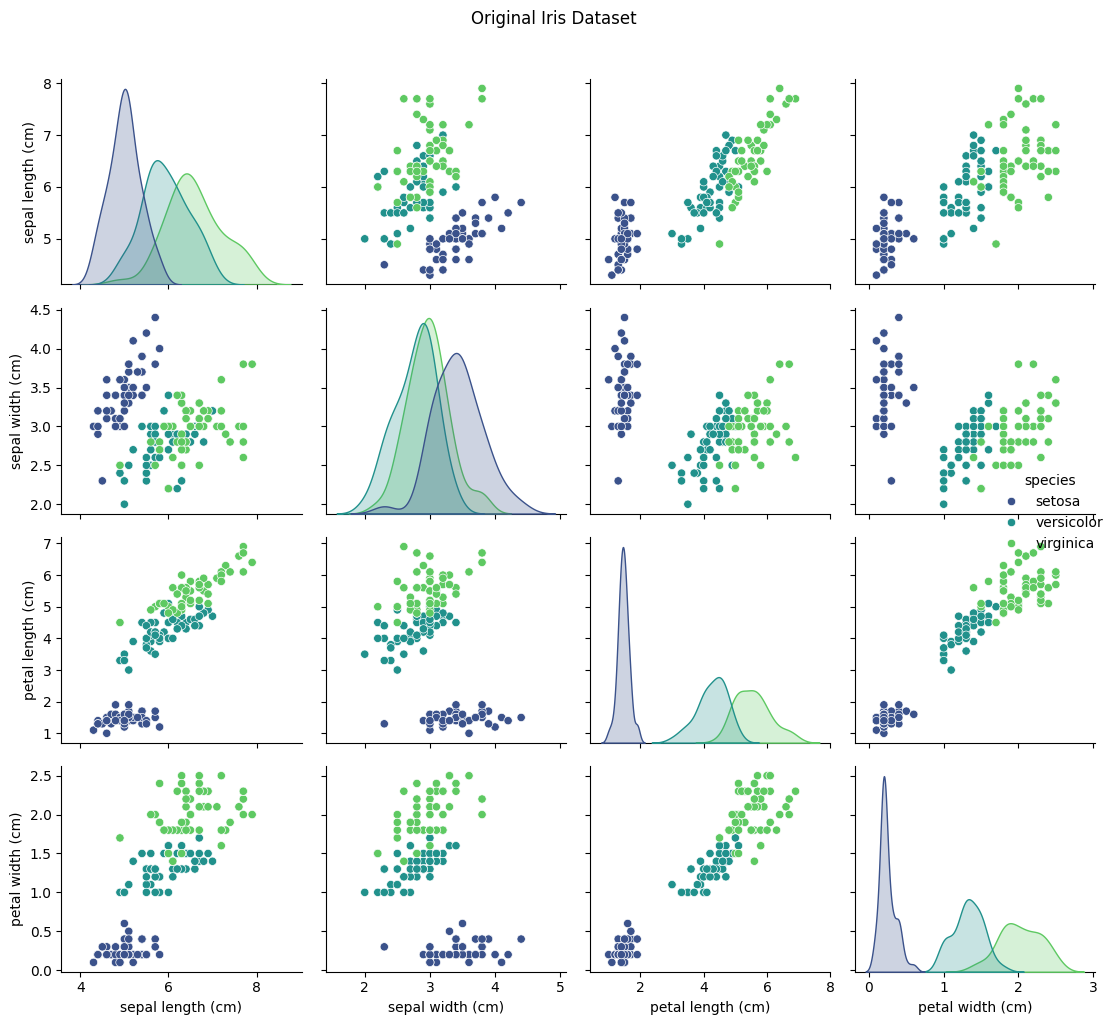

In [6]:
plt.figure(figsize=(12, 10))
sns.pairplot(df, hue='species', palette='viridis')
plt.suptitle('Original Iris Dataset', y=1.02)
plt.tight_layout()
plt.show()

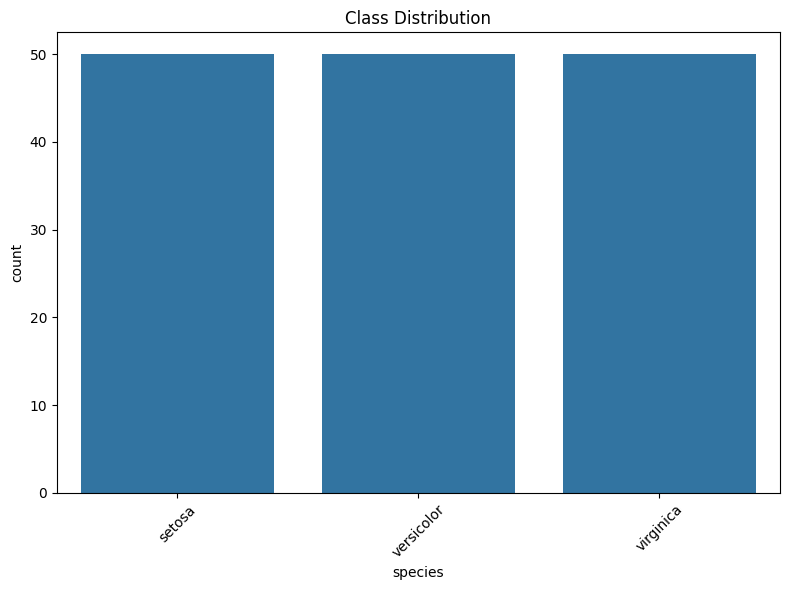

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x='species', data=df)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

In [11]:
print("\nBaseline Model Performance (Before Adding Noise):")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X, y, cv=5)
    print(f"{name}: Test Accuracy = {accuracy:.4f}, CV Accuracy = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Baseline Model Performance (Before Adding Noise):
Logistic Regression: Test Accuracy = 0.9111, CV Accuracy = 0.9733 ± 0.0249
K-Nearest Neighbors: Test Accuracy = 0.9111, CV Accuracy = 0.9733 ± 0.0249
Decision Tree: Test Accuracy = 0.9111, CV Accuracy = 0.9533 ± 0.0340
Random Forest: Test Accuracy = 0.8889, CV Accuracy = 0.9667 ± 0.0211
SVM: Test Accuracy = 0.9333, CV Accuracy = 0.9667 ± 0.0211


1. Gaussian Noise

In [12]:
def add_gaussian_noise(X, mean=0, std=0.1):
    noise = np.random.normal(mean, std, X.shape)
    return X + noise

2. Outlier

In [13]:
def add_outliers(X, percentage=0.05, scale=3.0):
    X_noisy = X.copy()
    n_samples, n_features = X.shape
    n_outliers = int(n_samples * percentage)    
    outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
    
    for idx in outlier_indices:
        feature_idx = np.random.randint(0, n_features)
        direction = 1 if np.random.random() > 0.5 else -1
        X_noisy[idx, feature_idx] += direction * scale * np.std(X[:, feature_idx])
    
    return X_noisy

3. Missing Values

In [14]:
def add_missing_values(X, percentage=0.03):
    X_missing = X.copy()
    n_samples, n_features = X.shape
    n_missing = int(n_samples * n_features * percentage)    
    rows = np.random.randint(0, n_samples, n_missing)
    cols = np.random.randint(0, n_features, n_missing)
    
    for i in range(n_missing):
        X_missing[rows[i], cols[i]] = np.nan
    
    return X_missing

4. Label Noise (Mislabeling)


In [15]:
def add_label_noise(y, percentage=0.05):
    y_noisy = y.copy()
    n_samples = len(y)
    n_noisy = int(n_samples * percentage)    
    noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)
    
    unique_labels = np.unique(y)
    for idx in noisy_indices:
        current_label = y[idx]
        possible_labels = [label for label in unique_labels if label != current_label]
        y_noisy[idx] = np.random.choice(possible_labels)
    
    return y_noisy

5. Feature Correlation (Multicollinearity)


In [16]:
def add_feature_correlation(X, correlation_strength=0.7):
    n_samples = X.shape[0]
    weights = np.random.uniform(-1, 1, X.shape[1])
    new_feature = correlation_strength * (X @ weights) + (1 - correlation_strength) * np.random.normal(0, 1, n_samples)
    
    new_feature = (new_feature - np.mean(new_feature)) / np.std(new_feature)
    X_with_correlation = np.column_stack((X, new_feature))
    
    return X_with_correlation

In [18]:
X_noisy = X.copy()

In [19]:
X_noisy = add_gaussian_noise(X_noisy, std=0.2)
X_noisy = add_outliers(X_noisy, percentage=0.05, scale=4.0)
X_noisy_with_missing = add_missing_values(X_noisy, percentage=0.05)
y_noisy = add_label_noise(y, percentage=0.08)


In [20]:
df_noisy = pd.DataFrame(X_noisy_with_missing, columns=feature_names)
df_noisy['species'] = pd.Categorical.from_codes(y_noisy, target_names)


In [21]:
print("\nNoisy Iris Dataset Summary:")
print(df_noisy.head())
print("\nMissing Values Count:")
print(df_noisy.isna().sum())


Noisy Iris Dataset Summary:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0           5.199343          3.472347           1.529538          0.504606   
1           4.853169               NaN           1.715843          0.353487   
2           4.606105          3.308512           1.207316          0.106854   
3           4.648392          2.717344           1.155016          0.087542   
4           4.797434          3.662849           1.218395         -0.082461   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  

Missing Values Count:
sepal length (cm)     5
sepal width (cm)     10
petal length (cm)     7
petal width (cm)      7
species               0
dtype: int64


In [23]:
# Handling missing values by imputation
df_noisy_imputed = df_noisy.copy()
for column in feature_names:
    df_noisy_imputed[column].fillna(df_noisy_imputed[column].mean(), inplace=True)


<Figure size 1200x1000 with 0 Axes>

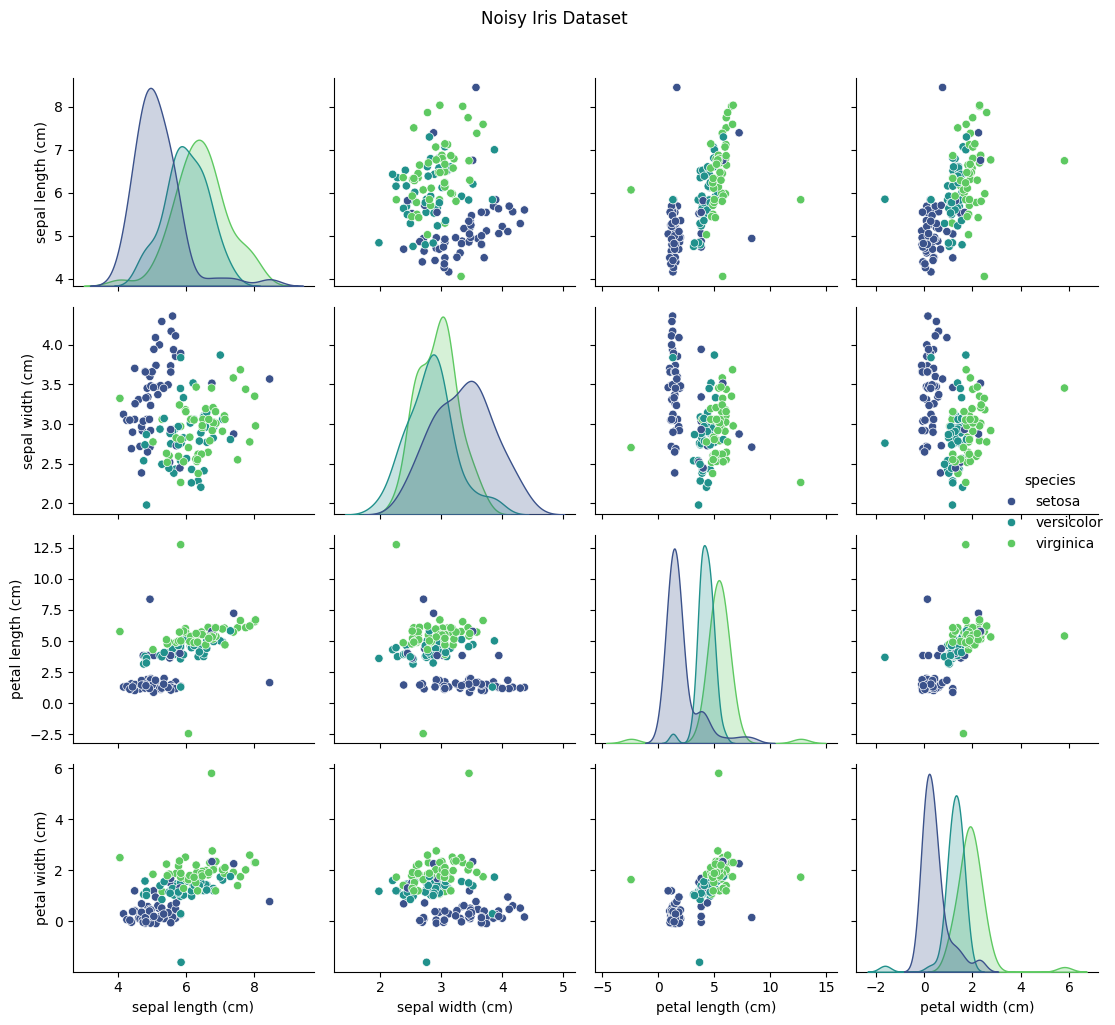

In [24]:
plt.figure(figsize=(12, 10))
sns.pairplot(df_noisy_imputed, hue='species', palette='viridis')
plt.suptitle('Noisy Iris Dataset', y=1.02)
plt.tight_layout()
plt.show()

In [25]:
X_noisy_with_correlation = add_feature_correlation(X_noisy)
extended_feature_names = feature_names + ['correlated_feature']

Creating a DF with correalted features

In [26]:
df_noisy_correlated = pd.DataFrame(X_noisy_with_correlation, columns=extended_feature_names)
df_noisy_correlated['species'] = pd.Categorical.from_codes(y_noisy, target_names)

In [27]:
# Filling the missing values in the correlated dataset
for column in extended_feature_names:
    if column in df_noisy_correlated.columns:
        df_noisy_correlated[column].fillna(df_noisy_correlated[column].mean(), inplace=True)

In [28]:
print("\nCorrelation Matrix of Features (with additional correlated feature):")
correlation_matrix = df_noisy_correlated[extended_feature_names].corr()
print(correlation_matrix)



Correlation Matrix of Features (with additional correlated feature):
                    sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)            1.000000         -0.095066           0.637435   
sepal width (cm)            -0.095066          1.000000          -0.416545   
petal length (cm)            0.637435         -0.416545           1.000000   
petal width (cm)             0.632855         -0.271980           0.711427   
correlated_feature          -0.140811          0.054983          -0.500480   

                    petal width (cm)  correlated_feature  
sepal length (cm)           0.632855           -0.140811  
sepal width (cm)           -0.271980            0.054983  
petal length (cm)           0.711427           -0.500480  
petal width (cm)            1.000000           -0.173279  
correlated_feature         -0.173279            1.000000  


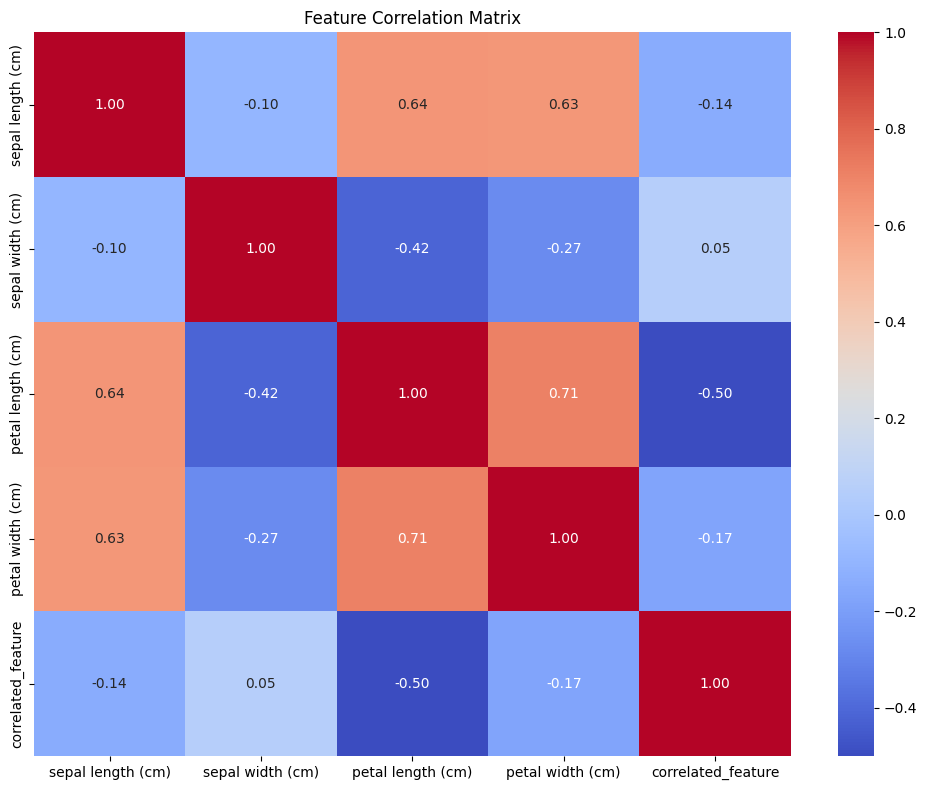

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [32]:
print("\nModel Performance on Noisy Data:")



Model Performance on Noisy Data:


In [31]:
X_noisy_imputed = df_noisy_imputed[feature_names].values
y_noisy = df_noisy_imputed['species'].cat.codes.values

In [33]:
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(
    X_noisy_imputed, y_noisy, test_size=0.3, random_state=42, stratify=y_noisy
)

In [34]:
scaler_noisy = StandardScaler()
X_train_noisy_scaled = scaler_noisy.fit_transform(X_train_noisy)
X_test_noisy_scaled = scaler_noisy.transform(X_test_noisy)

In [35]:
noisy_results = {}
for name, model in models.items():
    model.fit(X_train_noisy_scaled, y_train_noisy)
    y_pred_noisy = model.predict(X_test_noisy_scaled)
    accuracy = accuracy_score(y_test_noisy, y_pred_noisy)
    cv_scores = cross_val_score(model, X_noisy_imputed, y_noisy, cv=5)
    noisy_results[name] = accuracy
    print(f"{name}: Test Accuracy = {accuracy:.4f}, CV Accuracy = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Logistic Regression: Test Accuracy = 0.7778, CV Accuracy = 0.8067 ± 0.1218
K-Nearest Neighbors: Test Accuracy = 0.8000, CV Accuracy = 0.8467 ± 0.0957
Decision Tree: Test Accuracy = 0.8444, CV Accuracy = 0.8000 ± 0.0730
Random Forest: Test Accuracy = 0.7778, CV Accuracy = 0.8400 ± 0.0975
SVM: Test Accuracy = 0.8222, CV Accuracy = 0.8133 ± 0.0957


In [36]:
plt.figure(figsize=(12, 8))
model_names = list(models.keys())
original_scores = [accuracy_score(y_test, model.predict(X_test_scaled)) for model in models.values()]
noisy_scores = [noisy_results[name] for name in model_names]

<Figure size 1200x800 with 0 Axes>

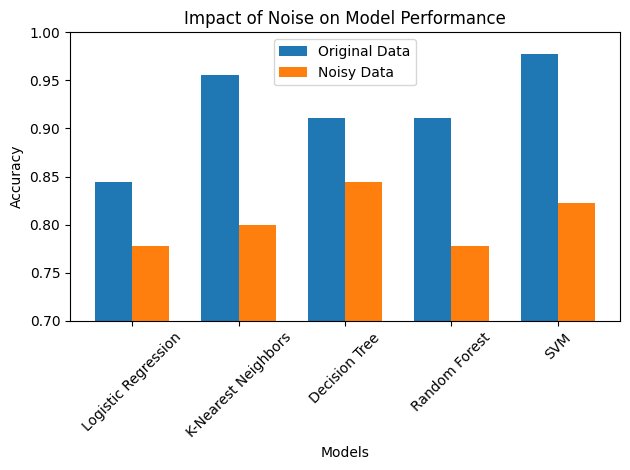

In [37]:
x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, original_scores, width, label='Original Data')
plt.bar(x + width/2, noisy_scores, width, label='Noisy Data')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Impact of Noise on Model Performance')
plt.xticks(x, model_names, rotation=45)
plt.ylim(0.7, 1.0)  # Adjust y-axis for better visibility
plt.legend()
plt.tight_layout()
plt.show()


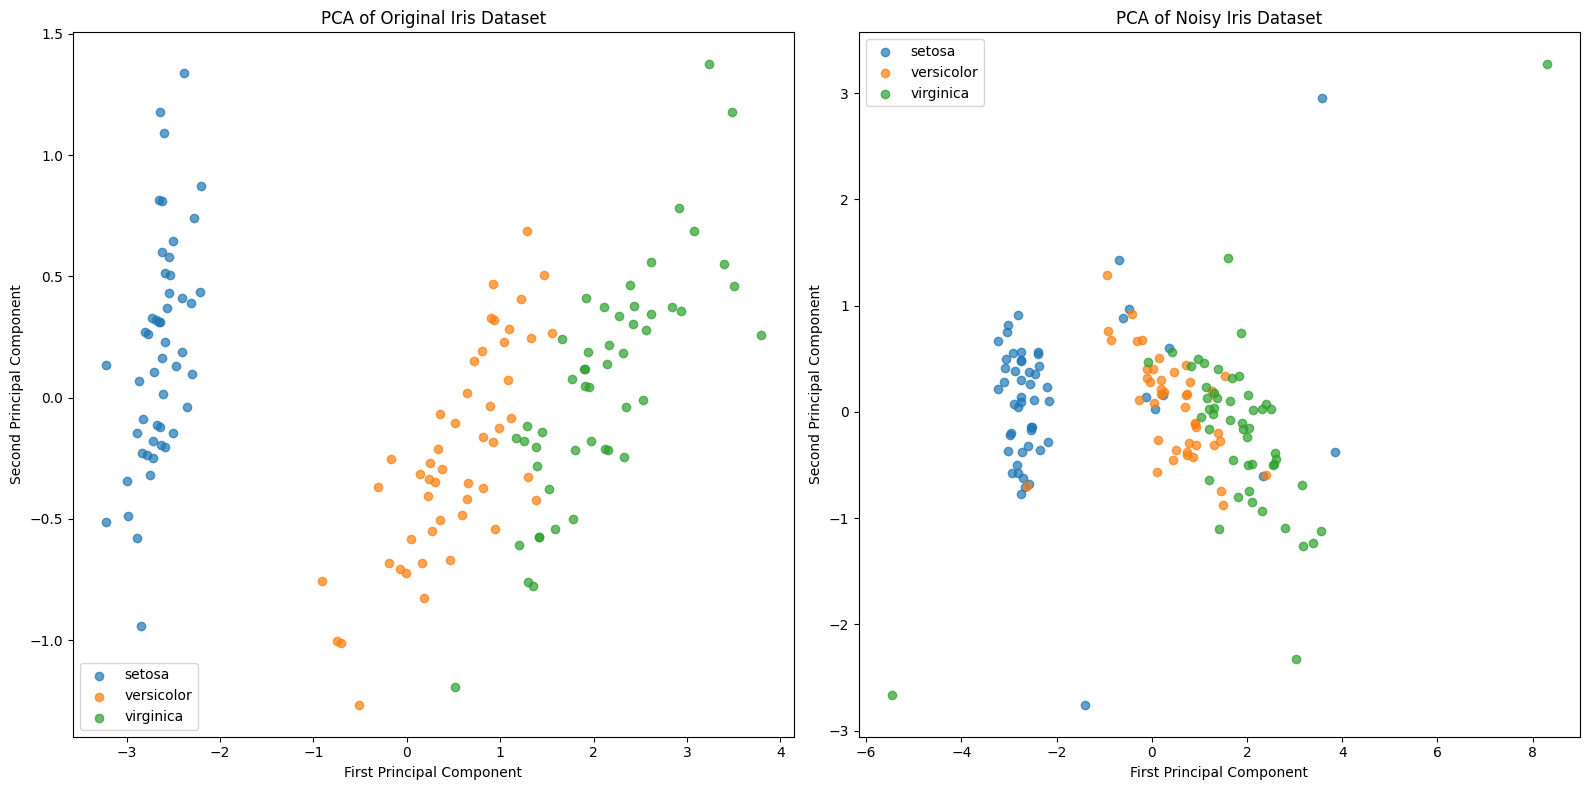

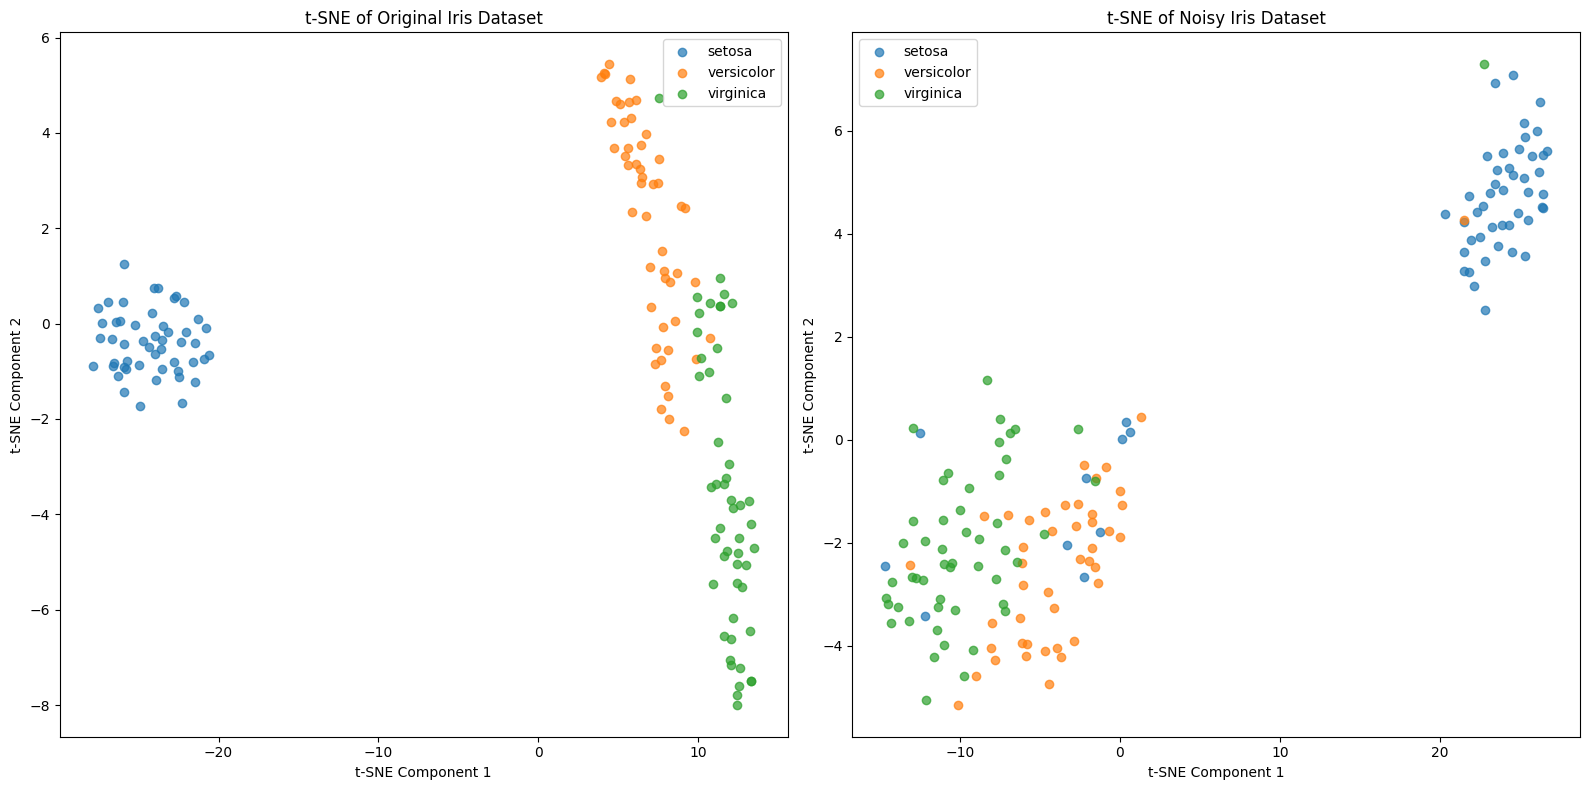

In [38]:
# PCA
pca = PCA(n_components=2)
X_pca_original = pca.fit_transform(X)
X_pca_noisy = pca.fit_transform(X_noisy_imputed)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne_original = tsne.fit_transform(X)
X_tsne_noisy = tsne.fit_transform(X_noisy_imputed)

# Visualize PCA results
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
for i, target_name in enumerate(target_names):
    plt.scatter(X_pca_original[y == i, 0], X_pca_original[y == i, 1], 
                label=target_name, alpha=0.7)
plt.title('PCA of Original Iris Dataset')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()

plt.subplot(1, 2, 2)
for i, target_name in enumerate(target_names):
    plt.scatter(X_pca_noisy[y_noisy == i, 0], X_pca_noisy[y_noisy == i, 1], 
                label=target_name, alpha=0.7)
plt.title('PCA of Noisy Iris Dataset')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize t-SNE results
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
for i, target_name in enumerate(target_names):
    plt.scatter(X_tsne_original[y == i, 0], X_tsne_original[y == i, 1], 
                label=target_name, alpha=0.7)
plt.title('t-SNE of Original Iris Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

plt.subplot(1, 2, 2)
for i, target_name in enumerate(target_names):
    plt.scatter(X_tsne_noisy[y_noisy == i, 0], X_tsne_noisy[y_noisy == i, 1], 
                label=target_name, alpha=0.7)
plt.title('t-SNE of Noisy Iris Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
# Strategies for handling noisy data
# 1. Robust Scaling
robust_scaler = RobustScaler()
X_train_noisy_robust = robust_scaler.fit_transform(X_train_noisy)
X_test_noisy_robust = robust_scaler.transform(X_test_noisy)

# 2. Model with regularization
log_reg_robust = LogisticRegression(C=0.1, random_state=42, max_iter=1000)  # Higher regularization
log_reg_robust.fit(X_train_noisy_robust, y_train_noisy)
log_reg_accuracy = accuracy_score(y_test_noisy, log_reg_robust.predict(X_test_noisy_robust))
print(f"Logistic Regression with Regularization and Robust Scaling: {log_reg_accuracy:.4f}")

Logistic Regression with Regularization and Robust Scaling: 0.7333


In [41]:
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42), 
                           n_estimators=50, random_state=42)
bagging.fit(X_train_noisy_scaled, y_train_noisy)
bagging_accuracy = accuracy_score(y_test_noisy, bagging.predict(X_test_noisy_scaled))
print(f"Bagging with Decision Trees: {bagging_accuracy:.4f}")

Bagging with Decision Trees: 0.7556


/home/anshuman/anaconda3/envs/30dml/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [42]:
# Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('lr', LogisticRegression(random_state=42, max_iter=1000)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
], voting='soft')
voting_clf.fit(X_train_noisy_scaled, y_train_noisy)
voting_accuracy = accuracy_score(y_test_noisy, voting_clf.predict(X_test_noisy_scaled))
print(f"Voting Classifier: {voting_accuracy:.4f}")

Voting Classifier: 0.8222


In [44]:
# Detect outliers
isolation_forest = IsolationForest(random_state=42, contamination=0.05)
outlier_preds = isolation_forest.fit_predict(X_noisy_imputed)
inlier_indices = np.where(outlier_preds == 1)[0]

In [45]:
# Training without outliers
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_noisy_imputed[inlier_indices], y_noisy[inlier_indices], 
    test_size=0.3, random_state=42, stratify=y_noisy[inlier_indices])

scaler_clean = StandardScaler()
X_train_clean_scaled = scaler_clean.fit_transform(X_train_clean)
X_test_clean_scaled = scaler_clean.transform(X_test_clean)
rf_clean = RandomForestClassifier(random_state=42)
rf_clean.fit(X_train_clean_scaled, y_train_clean)
rf_clean_accuracy = accuracy_score(y_test_clean, rf_clean.predict(X_test_clean_scaled))
print(f"Random Forest after Outlier Removal: {rf_clean_accuracy:.4f}")

Random Forest after Outlier Removal: 0.8372


In [46]:
print("1. Gaussian noise (measurement error)")
print("2. Outliers (abnormal observations)")
print("3. Missing values (data collection issues)")
print("4. Label noise (mislabeling)")
print("5. Feature correlation (multicollinearity)")
print("\nThese noise types affected model performance differently, with some models being more robust than others.")
print("Strategies like robust scaling, regularization, ensemble methods, and outlier detection help mitigate noise effects.")

1. Gaussian noise (measurement error)
2. Outliers (abnormal observations)
3. Missing values (data collection issues)
4. Label noise (mislabeling)
5. Feature correlation (multicollinearity)

These noise types affected model performance differently, with some models being more robust than others.
Strategies like robust scaling, regularization, ensemble methods, and outlier detection help mitigate noise effects.
